## Imports and Random Seed

In [1]:
import os, random, numpy as np, torch

SEED = 42
# 1️⃣  Pure‑Python & NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# 2️⃣  Threading / BLAS
os.environ["OMP_NUM_THREADS"]  = "1"   # OpenMP
os.environ["MKL_NUM_THREADS"]  = "1"   # MKL / NumPy
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

torch.set_deterministic_debug_mode(True)


# 3️⃣  CUDA (skip if you stay on CPU), *before* importing torch.cuda
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"   # or ":4096:8" for big convs

# 4️⃣  PyTorch itself
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)           # safe even if CUDA not present
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
torch.use_deterministic_algorithms(True)   # 🔒 raise on nondet ops


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch and related imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# For splitting and metrics
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error



In [3]:
import random; import numpy as np; import torch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



#### 1) Load CSV and stratified split data



In [4]:
CSV_PATH = '../../../data-prep/MOS.csv'
IMG_DIR = '../../../static'


In [5]:
df = pd.read_csv(CSV_PATH)

# Create bins for stratification
n_bins = 10  # You can adjust this number
df['MOS_bin'] = pd.qcut(df['MOS'], n_bins, labels=False)



assert 'filename' in df.columns, f"Expected 'filename' column, got {df.columns}"
assert 'MOS'      in df.columns, f"Expected 'MOS' column, got {df.columns}"
assert not df[['filename','MOS']].isnull().any().any(), "Found NaNs in filenames or MOS"
dupes = df['filename'][df['filename'].duplicated()]
assert dupes.empty, f"Duplicate filenames: {dupes.tolist()}"

df.head()


,filename,MOS,MOS_bin
0,f1.png,47.058940,1
1,f10.png,59.343239,2
2,f100.png,67.845299,4
3,f101.png,66.061042,4
4,f102.png,55.699696,2


In [6]:
# Stratified split
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=SEED, stratify=df['MOS_bin'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df['MOS_bin'])

# Drop the bin column as it's no longer needed
train_df = train_df.drop(columns=['MOS_bin'])
val_df = val_df.drop(columns=['MOS_bin'])
test_df = test_df.drop(columns=['MOS_bin'])


In [7]:
# Stratified split sanity (Disjoint splits)
train_ids = set(train_df.index)
val_ids   = set(val_df.index)
test_ids  = set(test_df.index)
assert train_ids.isdisjoint(val_ids) and train_ids.isdisjoint(test_ids) and val_ids.isdisjoint(test_ids), "Overlap between splits!"


# Compute mean & std on the TRAIN set only
mos_mean = train_df['MOS'].mean()
mos_std  = train_df['MOS'].std()

# Apply z-score normalization to all three splits
for df_split in (train_df, val_df, test_df):
    df_split['MOS'] = (df_split['MOS'] - mos_mean) / mos_std



#### Visualize MOS Score Distribution Across Splits




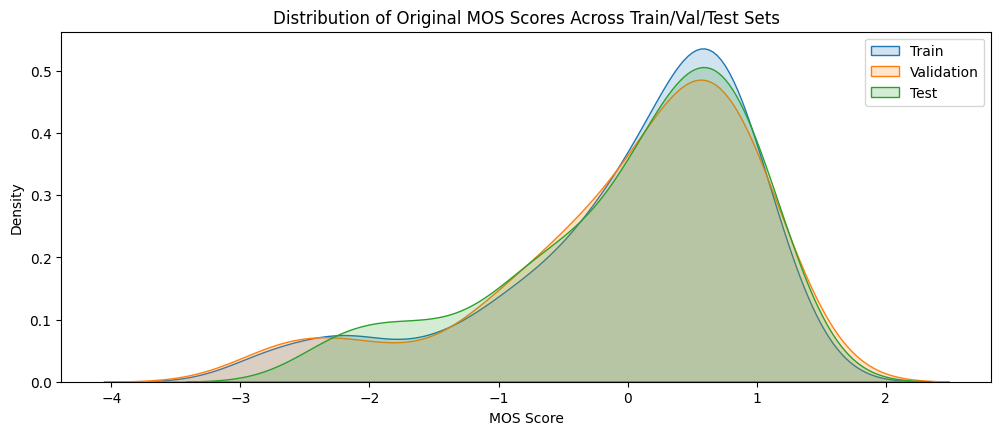

In [8]:
import seaborn as sns


plt.figure(figsize=(12, 10))

# Original MOS distributions (before normalization)
plt.subplot(2, 1, 1)
sns.kdeplot(train_df['MOS'], label='Train', fill=True, alpha=0.2)
sns.kdeplot(val_df['MOS'], label='Validation', fill=True, alpha=0.2)
sns.kdeplot(test_df['MOS'], label='Test', fill=True, alpha=0.2)
plt.title('Distribution of Original MOS Scores Across Train/Val/Test Sets')
plt.xlabel('MOS Score')
plt.ylabel('Density')
plt.legend()


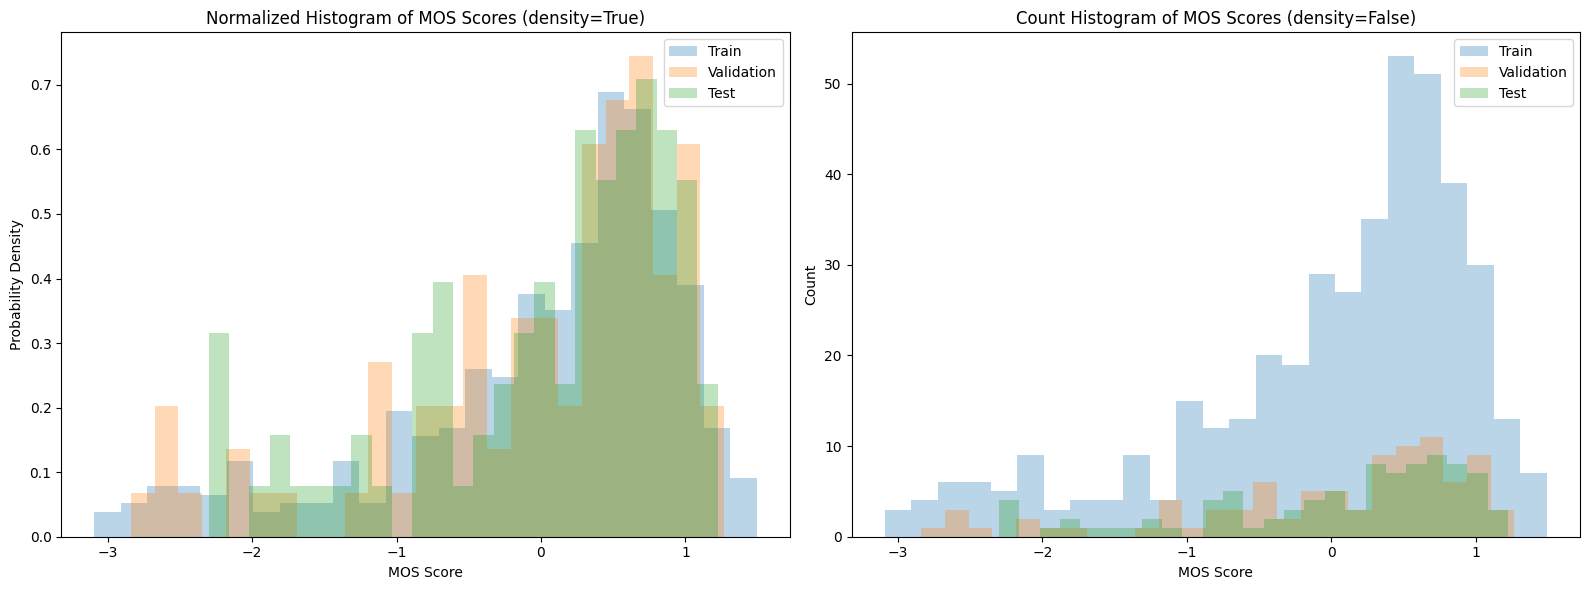

In [9]:
# Create histograms to better see the actual distributions
plt.figure(figsize=(16, 6))

# Left subplot with density=True (normalized)
plt.subplot(1, 2, 1)
plt.hist(train_df['MOS'], bins=25, alpha=0.3, label='Train', density=True)
plt.hist(val_df['MOS'], bins=25, alpha=0.3, label='Validation', density=True)
plt.hist(test_df['MOS'], bins=25, alpha=0.3, label='Test', density=True)
plt.title('Normalized Histogram of MOS Scores (density=True)')
plt.xlabel('MOS Score')
plt.ylabel('Probability Density')
plt.legend()

# Right subplot with density=False (count)
plt.subplot(1, 2, 2)
plt.hist(train_df['MOS'], bins=25, alpha=0.3, label='Train', density=False)
plt.hist(val_df['MOS'], bins=25, alpha=0.3, label='Validation', density=False)
plt.hist(test_df['MOS'], bins=25, alpha=0.3, label='Test', density=False)
plt.title('Count Histogram of MOS Scores (density=False)')
plt.xlabel('MOS Score')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()


Statistics for MOS (z-normalized)


,Split,Count,Mean,Std,Min,25%,Median,75%,Max
0,Train,420,0.0000,1.0000,-3.0909,-0.4237,0.2976,0.7205,1.4920
1,Validation,90,-0.0031,1.0015,-2.8380,-0.4127,0.3143,0.7185,1.2678
2,Test,90,0.0346,0.9219,-2.2998,-0.5278,0.2782,0.7092,1.2234


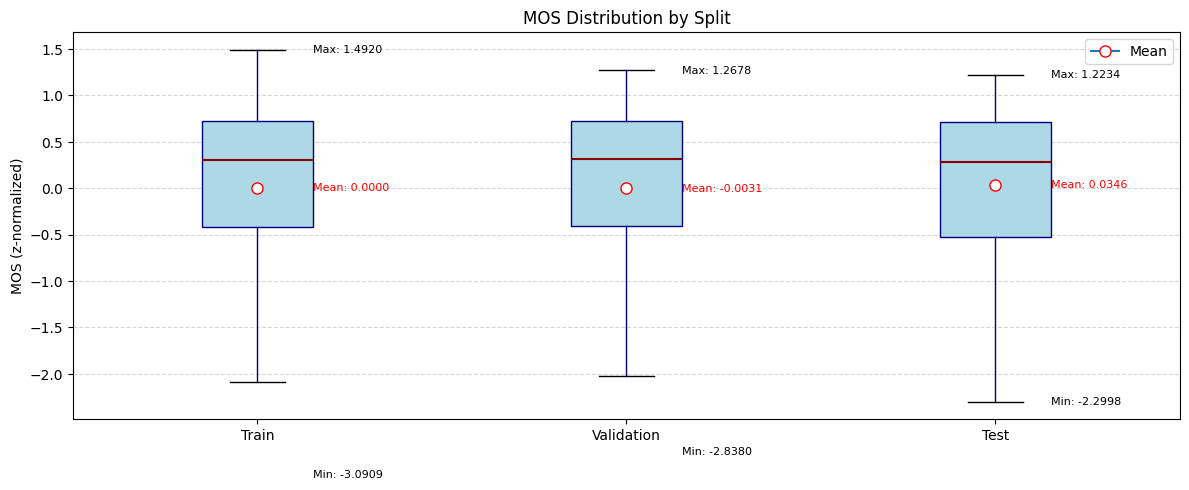

In [10]:
# Create summary statistics for each split
split_dfs = {
    'Train': train_df,
    'Validation': val_df, 
    'Test': test_df
}

# Make sure we're using the same column ('MOS') for everything
mos_column = 'MOS'

# Generate statistics
stats_df = pd.DataFrame({
    'Split': split_dfs.keys(),
    'Count': [df.shape[0] for df in split_dfs.values()],
    'Mean': [df[mos_column].mean() for df in split_dfs.values()],
    'Std': [df[mos_column].std() for df in split_dfs.values()],
    'Min': [df[mos_column].min() for df in split_dfs.values()],
    '25%': [df[mos_column].quantile(0.25) for df in split_dfs.values()],
    'Median': [df[mos_column].median() for df in split_dfs.values()],
    '75%': [df[mos_column].quantile(0.75) for df in split_dfs.values()],
    'Max': [df[mos_column].max() for df in split_dfs.values()]
})

# Display styled statistics table
print("Statistics for MOS (z-normalized)")
display(stats_df.style.background_gradient(cmap='Blues', subset=['Mean', 'Std', 'Min', 'Max'])
        .format(precision=4)
        .set_caption('MOS Statistics Across Data Splits (z-normalized)'))

# Create visualizations in a single figure
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))

# Box plot - explicitly using the same data as in the statistics
mos_data = [df[mos_column] for df in split_dfs.values()]

# Add annotations to the boxplot for verification
bp = ax1.boxplot(mos_data,
           tick_labels=split_dfs.keys(),
           showfliers=False,
           patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='navy'),
           whiskerprops=dict(color='navy'),
           medianprops=dict(color='darkred', linewidth=1.5))

# Add mean markers to boxplot
for i, data in enumerate(mos_data):
    mean = data.mean()
    ax1.plot(i+1, mean, marker='o', markerfacecolor='white', markeredgecolor='red', 
             markersize=8, label='Mean' if i==0 else "")

ax1.set_ylabel('MOS (z-normalized)')
ax1.set_title('MOS Distribution by Split')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.legend()

# Add text annotations for min, mean, median, max
for i, data in enumerate(mos_data):
    min_val = data.min()
    max_val = data.max()
    mean_val = data.mean()
    median_val = data.median()
    
    # Add text annotations slightly offset from the plot
    ax1.text(i+1.15, min_val, f'Min: {min_val:.4f}', fontsize=8, ha='left', va='center')
    ax1.text(i+1.15, max_val, f'Max: {max_val:.4f}', fontsize=8, ha='left', va='center')
    ax1.text(i+1.15, mean_val, f'Mean: {mean_val:.4f}', fontsize=8, ha='left', va='center', color='red')

plt.tight_layout()
plt.show()


In [11]:
from IPython.display import display_html, HTML

# Get the shapes
train_shape = train_df.shape
val_shape = val_df.shape
test_shape = test_df.shape

# Function to convert dataframe to styled HTML with shape info
def df_to_html_with_shape(df, title, shape):
    shape_str = f"Shape: {shape[0]} rows × {shape[1]} columns"
    styled_html = f"""
    <div style="margin-right: 10px; display: inline-block; vertical-align: top; width: 31%;">
        <h3 style="text-align: center; color: #0066cc;">{title}</h3>
        <p style="text-align: center; font-style: italic; margin-bottom: 5px;">{shape_str}</p>
        {df.head(4).style.set_table_attributes('class="dataframe" style="width: 100%;"').to_html()}
    </div>
    """
    return styled_html

# Combine all three HTML tables
all_tables_html = df_to_html_with_shape(train_df, "Training Data", train_shape) + \
                 df_to_html_with_shape(val_df, "Validation Data", val_shape) + \
                 df_to_html_with_shape(test_df, "Test Data", test_shape)

# Create a container
container_html = f"""
<div style="display: flex; justify-content: space-between; width: 100%;">
    {all_tables_html}
</div>
"""

# Display the HTML
display_html(HTML(container_html))


,filename,MOS
255,f329.png,0.134646
241,f316.png,-0.954147
175,f257.png,0.978417
119,f206.png,-3.041686
,filename,MOS
445,f68.png,-0.149500
102,f191.png,-0.241829
198,f278.png,0.154798
439,f62.png,0.469404
,filename,MOS


Total: 600 rows (because we have 600 images)



#### 3) Create a PyTorch Dataset and DataLoader



In [12]:
# Set image dimensions
HEIGHT, WIDTH = 384, 512

# Define transforms for training and evaluation
train_transforms = transforms.Compose([
    # Data augmentation (random horizontal and vertical flip)
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=10), # Random rotation (±10 degrees)

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # small rotations
    transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes



    transforms.ToTensor(), # Convert image to tensor and scale pixel values to [0,1]
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# For validation and testing we only need to convert to tensor.
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# Simpler transform: only ToTensor + Normalize
simple_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])




In [13]:
class ImageMOSDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with columns 'filename' and 'MOS'
            img_dir (str): Directory with all the images.
            transform: torchvision transforms to apply to images.
        """

        missing = [f for f in dataframe['filename'] if not os.path.isfile(os.path.join(img_dir, f))]
        assert not missing, f"Missing image files: {missing[:5]}…"

        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the image filename and full path
        filename = self.dataframe.loc[idx, 'filename']
        img_path = os.path.join(self.img_dir, filename)
        # Open image and ensure it is RGB
        image = Image.open(img_path).convert("RGB")

        
        if self.transform:
            image = self.transform(image)
        

        # Get the normalized MOS value as a float tensor
        mos = torch.tensor(self.dataframe.loc[idx, 'MOS'], dtype=torch.float32)

        assert isinstance(image, torch.Tensor)
        assert image.shape == (3, HEIGHT, WIDTH), f"Got shape {image.shape}"
        assert  torch.isfinite(mos), "MOS is not finite"


        return image, mos



In [14]:
train_dataset = ImageMOSDataset(train_df, IMG_DIR, transform=train_transforms)
val_dataset   = ImageMOSDataset(val_df,   IMG_DIR, transform=eval_transforms)
test_dataset  = ImageMOSDataset(test_df,  IMG_DIR, transform=eval_transforms)

# Print the number of images in each dataset
print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")



Number of images in training dataset: 420
Number of images in validation dataset: 90
Number of images in test dataset: 90


In [15]:
BATCH_SIZE = 32 # Create DataLoaders


g = torch.Generator().manual_seed(SEED)

def worker_init_fn(worker_id):
    # guarantees that each DataLoader worker reproduces its own stream
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)



# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, generator=g)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn  # Change from None to worker_init_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn  # Change from None to worker_init_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn  # Change from None to worker_init_fn
)

# val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, generator=g)
# test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, generator=g)


In [16]:
first_batch = next(iter(train_loader))
print("First batch sample MOS values:", first_batch[1][:5].tolist())


First batch sample MOS values: [-0.7934278845787048, 0.8394438624382019, -0.19277027249336243, 0.03462066873908043, 1.1148629188537598]


In [17]:
imgs, moss = next(iter(train_loader))
# check batch dims/types
assert imgs.ndim == 4 and imgs.shape[1:] == (3,HEIGHT,WIDTH)
assert moss.ndim == 1 and moss.dtype == torch.float32



In [18]:
# imgs.shape, moss.shape


There is only one image when we iterate through the train_dataset


In [19]:
for i in range(10):
    img, mos = train_dataset[i]
    print(img.shape, mos.item())


torch.Size([3, 384, 512]) 0.13464580476284027
torch.Size([3, 384, 512]) -0.954147458076477
torch.Size([3, 384, 512]) 0.978416919708252
torch.Size([3, 384, 512]) -3.0416858196258545
torch.Size([3, 384, 512]) -0.19277027249336243
torch.Size([3, 384, 512]) -0.411110520362854
torch.Size([3, 384, 512]) 0.9699268937110901
torch.Size([3, 384, 512]) 0.48901858925819397
torch.Size([3, 384, 512]) 1.2568248510360718
torch.Size([3, 384, 512]) 0.35381844639778137


There are 32 images in one batch of the train_loader


In [20]:
for img, mos in train_loader:
    print(img.shape, mos.shape)
    j=0
    for i, mos_ in zip(img, mos):
        print(f"-== --== -\nCOUNT{j}\n-----")
        print(f"Image shape: {i.shape}\nMOS: {mos_}")
        j+=1
    break


torch.Size([32, 3, 384, 512]) torch.Size([32])
-== --== -
COUNT0
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.9462814927101135
-== --== -
COUNT1
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.7497540712356567
-== --== -
COUNT2
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.07069732993841171
-== --== -
COUNT3
-----
Image shape: torch.Size([3, 384, 512])
MOS: -0.4717830419540405
-== --== -
COUNT4
-----
Image shape: torch.Size([3, 384, 512])
MOS: -0.08805374801158905
-== --== -
COUNT5
-----
Image shape: torch.Size([3, 384, 512])
MOS: -0.07966345548629761
-== --== -
COUNT6
-----
Image shape: torch.Size([3, 384, 512])
MOS: 1.0192173719406128
-== --== -
COUNT7
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.961453378200531
-== --== -
COUNT8
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.39313140511512756
-== --== -
COUNT9
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.3120872378349304
-== --== -
COUNT10
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.047562

#### 4) Create the Model




In [21]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()

        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)  # (384x512 → 192x256)
        )

        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 96x128
        )

        # Third convolutional block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 48x64
        )

        # Fourth convolutional block
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 24x32
        )
        
        # Fifth convolutional block (added)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 12x16
        )

        # Global average pooling instead of flattening
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Output: 256x1x1
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

# Instantiate the model and send to device (GPU if available)
device = torch.device("mps" if torch.mps.is_available() else "cpu")
# device = torch.device("cpu")

print(device)
model = SimpleCNN().to(device)
print(model)


mps
SimpleCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 434,817


### Training loop


In [23]:
# Define multiple loss functions
loss_functions = {
    'mse': nn.MSELoss(),
    'mae': nn.L1Loss(),
    'huber': nn.SmoothL1Loss(),  # Combination of L1 and L2 loss
}

# Function to compute SROCC loss (negative Spearman correlation)
def srocc_loss(pred, target):
    # Convert tensors to cpu and numpy
    pred_np = pred.detach().cpu().numpy().flatten()
    target_np = target.detach().cpu().numpy().flatten()
    
    # Compute Spearman correlation coefficient
    srocc = spearmanr(pred_np, target_np)[0]
    
    # Return negative correlation as loss (higher correlation = lower loss)
    # Handle NaN values that can occur with constant predictions
    if np.isnan(srocc):
        return torch.tensor(1.0, device=pred.device, requires_grad=True)
    return torch.tensor(1.0 - srocc, device=pred.device, requires_grad=True)

# Add custom SROCC loss to dictionary
loss_functions['srocc'] = srocc_loss

# Function to train model with specified loss functions
def train_model(model, train_loader, val_loader, loss_fns, optimizer, epochs=75, device='cpu'):
    # Initialize tracking variables
    train_losses = {name: [] for name in loss_fns.keys()}
    val_losses = {name: [] for name in loss_fns.keys()}
    
    # Use first loss function as primary training objective
    primary_loss_name = list(loss_fns.keys())[0]
    primary_loss_fn = loss_fns[primary_loss_name]
    
    # Best model tracking
    best_val_loss = float('inf')
    best_model_weights = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_batch_losses = {name: 0.0 for name in loss_fns.keys()}
        num_samples = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)  # ensure labels are (batch, 1)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # Compute primary loss for backpropagation
            loss = primary_loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Record batch size
            batch_size = images.size(0)
            num_samples += batch_size
            
            # Compute and store all losses for monitoring
            for name, loss_fn in loss_fns.items():
                if name == primary_loss_name:
                    # Already computed this loss
                    batch_loss = loss.item() * batch_size
                else:
                    # Compute other losses for monitoring only
                    with torch.no_grad():
                        batch_loss = loss_fn(outputs, labels).item() * batch_size
                        
                        # Special handling for SROCC which isn't averaged by batch size
                        if name == 'srocc':
                            batch_loss = loss_fn(outputs, labels).item()
                
                train_batch_losses[name] += batch_loss
        
        # Compute epoch losses
        for name in loss_fns.keys():
            if name == 'srocc':
                # SROCC loss isn't averaged by batch size
                epoch_loss = train_batch_losses[name]
            else:
                epoch_loss = train_batch_losses[name] / num_samples
            train_losses[name].append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_batch_losses = {name: 0.0 for name in loss_fns.keys()}
        num_val_samples = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(images)
                
                batch_size = images.size(0)
                num_val_samples += batch_size
                
                # Compute all validation losses
                for name, loss_fn in loss_fns.items():
                    batch_loss = loss_fn(outputs, labels).item()
                    
                    # Special handling for SROCC which isn't averaged by batch size
                    if name != 'srocc':
                        batch_loss *= batch_size
                    
                    val_batch_losses[name] += batch_loss
        
        # Compute validation epoch losses
        for name in loss_fns.keys():
            if name == 'srocc':
                # SROCC loss isn't averaged by batch size
                val_epoch_loss = val_batch_losses[name]
            else:
                val_epoch_loss = val_batch_losses[name] / num_val_samples
            val_losses[name].append(val_epoch_loss)
        
        # Print progress
        log_str = f"Epoch {epoch+1}/{epochs}"
        for name in loss_fns.keys():
            log_str += f"  Train {name}: {train_losses[name][-1]:.4f}  Val {name}: {val_losses[name][-1]:.4f}"
        print(log_str)
        
        # Save best model (using primary loss)
        val_primary_loss = val_losses[primary_loss_name][-1]
        if val_primary_loss < best_val_loss:
            best_val_loss = val_primary_loss
            best_model_weights = model.state_dict().copy()
    
    # Load best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    
    return model, train_losses, val_losses


In [24]:
# Define which loss functions to use
selected_losses = {
    'mse': loss_functions['mse'],   # Primary loss for training
    'mae': loss_functions['mae'],   # Monitor MAE
    'huber': loss_functions['huber'] # Monitor Huber loss
}

# Train model
EPOCHS = 75
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-8, weight_decay=0)
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, 
    selected_losses, optimizer, EPOCHS, device
)


Epoch 1/75  Train mse: 1.0007  Val mse: 1.0096  Train mae: 0.7592  Val mae: 0.7566  Train huber: 0.3933  Val huber: 0.3892


Epoch 2/75  Train mse: 0.9662  Val mse: 1.0129  Train mae: 0.7569  Val mae: 0.7493  Train huber: 0.3879  Val huber: 0.3867


Epoch 3/75  Train mse: 0.9123  Val mse: 0.9186  Train mae: 0.7420  Val mae: 0.7296  Train huber: 0.3723  Val huber: 0.3676


Epoch 4/75  Train mse: 0.8821  Val mse: 0.8784  Train mae: 0.7415  Val mae: 0.7293  Train huber: 0.3711  Val huber: 0.3662


Epoch 5/75  Train mse: 0.8420  Val mse: 0.8262  Train mae: 0.7232  Val mae: 0.6670  Train huber: 0.3581  Val huber: 0.3331


Epoch 6/75  Train mse: 0.8240  Val mse: 0.8155  Train mae: 0.7015  Val mae: 0.7020  Train huber: 0.3481  Val huber: 0.3460


Epoch 7/75  Train mse: 0.8231  Val mse: 0.8180  Train mae: 0.7075  Val mae: 0.6590  Train huber: 0.3477  Val huber: 0.3317


Epoch 8/75  Train mse: 0.7963  Val mse: 0.8077  Train mae: 0.6783  Val mae: 0.6493  Train huber: 0.3353  Val huber: 0.3221


Epoch 9/75  Train mse: 0.8065  Val mse: 0.7786  Train mae: 0.6944  Val mae: 0.6640  Train huber: 0.3461  Val huber: 0.3234


Epoch 10/75  Train mse: 0.7360  Val mse: 0.8027  Train mae: 0.6613  Val mae: 0.6696  Train huber: 0.3183  Val huber: 0.3277


Epoch 11/75  Train mse: 0.7229  Val mse: 0.8733  Train mae: 0.6505  Val mae: 0.6473  Train huber: 0.3110  Val huber: 0.3317


Epoch 12/75  Train mse: 0.7647  Val mse: 0.7920  Train mae: 0.6523  Val mae: 0.6632  Train huber: 0.3203  Val huber: 0.3210


Epoch 13/75  Train mse: 0.7072  Val mse: 0.8325  Train mae: 0.6500  Val mae: 0.6847  Train huber: 0.3076  Val huber: 0.3400


Epoch 14/75  Train mse: 0.7012  Val mse: 0.8661  Train mae: 0.6511  Val mae: 0.6527  Train huber: 0.3072  Val huber: 0.3304


Epoch 15/75  Train mse: 0.6849  Val mse: 0.8706  Train mae: 0.6171  Val mae: 0.6756  Train huber: 0.2920  Val huber: 0.3404


Epoch 16/75  Train mse: 0.6846  Val mse: 0.7964  Train mae: 0.6318  Val mae: 0.6953  Train huber: 0.2957  Val huber: 0.3386


Epoch 17/75  Train mse: 0.6760  Val mse: 0.9431  Train mae: 0.6196  Val mae: 0.6690  Train huber: 0.2887  Val huber: 0.3501


Epoch 18/75  Train mse: 0.6918  Val mse: 0.8505  Train mae: 0.6255  Val mae: 0.6600  Train huber: 0.2995  Val huber: 0.3312


Epoch 19/75  Train mse: 0.7378  Val mse: 0.8885  Train mae: 0.6654  Val mae: 0.6586  Train huber: 0.3174  Val huber: 0.3365


Epoch 20/75  Train mse: 0.7167  Val mse: 0.8335  Train mae: 0.6463  Val mae: 0.7103  Train huber: 0.3075  Val huber: 0.3526


Epoch 21/75  Train mse: 0.6872  Val mse: 0.8109  Train mae: 0.6489  Val mae: 0.6387  Train huber: 0.3032  Val huber: 0.3186


Epoch 22/75  Train mse: 0.6918  Val mse: 0.8416  Train mae: 0.6519  Val mae: 0.6524  Train huber: 0.3060  Val huber: 0.3262


Epoch 23/75  Train mse: 0.6942  Val mse: 0.8138  Train mae: 0.6385  Val mae: 0.6610  Train huber: 0.2991  Val huber: 0.3245


Epoch 24/75  Train mse: 0.6371  Val mse: 0.7907  Train mae: 0.6182  Val mae: 0.6520  Train huber: 0.2838  Val huber: 0.3166


Epoch 25/75  Train mse: 0.6817  Val mse: 0.8928  Train mae: 0.6225  Val mae: 0.6468  Train huber: 0.2947  Val huber: 0.3350


Epoch 26/75  Train mse: 0.6383  Val mse: 0.9740  Train mae: 0.6137  Val mae: 0.6479  Train huber: 0.2785  Val huber: 0.3501


Epoch 27/75  Train mse: 0.6907  Val mse: 0.8685  Train mae: 0.6456  Val mae: 0.6634  Train huber: 0.3036  Val huber: 0.3358


Epoch 28/75  Train mse: 0.6247  Val mse: 0.8251  Train mae: 0.6087  Val mae: 0.6526  Train huber: 0.2766  Val huber: 0.3241


Epoch 29/75  Train mse: 0.6350  Val mse: 0.8350  Train mae: 0.6099  Val mae: 0.6885  Train huber: 0.2795  Val huber: 0.3413


Epoch 30/75  Train mse: 0.6441  Val mse: 0.9002  Train mae: 0.6123  Val mae: 0.6600  Train huber: 0.2835  Val huber: 0.3373


Epoch 31/75  Train mse: 0.5915  Val mse: 0.8551  Train mae: 0.5850  Val mae: 0.6739  Train huber: 0.2592  Val huber: 0.3344


Epoch 32/75  Train mse: 0.5708  Val mse: 0.9793  Train mae: 0.5805  Val mae: 0.6732  Train huber: 0.2547  Val huber: 0.3563


Epoch 33/75  Train mse: 0.6222  Val mse: 0.8418  Train mae: 0.6044  Val mae: 0.6641  Train huber: 0.2723  Val huber: 0.3310


Epoch 34/75  Train mse: 0.6109  Val mse: 0.8429  Train mae: 0.5975  Val mae: 0.6698  Train huber: 0.2676  Val huber: 0.3355


Epoch 35/75  Train mse: 0.6418  Val mse: 0.8806  Train mae: 0.6134  Val mae: 0.6659  Train huber: 0.2822  Val huber: 0.3367


Epoch 36/75  Train mse: 0.5720  Val mse: 0.8855  Train mae: 0.5770  Val mae: 0.6802  Train huber: 0.2545  Val huber: 0.3430


Epoch 37/75  Train mse: 0.6046  Val mse: 0.9013  Train mae: 0.5852  Val mae: 0.6609  Train huber: 0.2629  Val huber: 0.3389


Epoch 38/75  Train mse: 0.5891  Val mse: 0.8980  Train mae: 0.5914  Val mae: 0.6816  Train huber: 0.2620  Val huber: 0.3455


Epoch 39/75  Train mse: 0.5888  Val mse: 0.8991  Train mae: 0.5881  Val mae: 0.6644  Train huber: 0.2591  Val huber: 0.3400


Epoch 40/75  Train mse: 0.5580  Val mse: 0.8816  Train mae: 0.5647  Val mae: 0.7007  Train huber: 0.2473  Val huber: 0.3512


Epoch 41/75  Train mse: 0.5944  Val mse: 0.8798  Train mae: 0.5861  Val mae: 0.6820  Train huber: 0.2619  Val huber: 0.3474


Epoch 42/75  Train mse: 0.6212  Val mse: 0.8560  Train mae: 0.6071  Val mae: 0.6827  Train huber: 0.2747  Val huber: 0.3406


Epoch 43/75  Train mse: 0.6022  Val mse: 0.8685  Train mae: 0.5880  Val mae: 0.6805  Train huber: 0.2605  Val huber: 0.3448


Epoch 44/75  Train mse: 0.5586  Val mse: 0.8853  Train mae: 0.5766  Val mae: 0.6692  Train huber: 0.2522  Val huber: 0.3434


Epoch 45/75  Train mse: 0.5374  Val mse: 0.8711  Train mae: 0.5511  Val mae: 0.6837  Train huber: 0.2380  Val huber: 0.3416


Epoch 46/75  Train mse: 0.5591  Val mse: 0.8658  Train mae: 0.5737  Val mae: 0.7242  Train huber: 0.2505  Val huber: 0.3702


Epoch 47/75  Train mse: 0.5401  Val mse: 0.9070  Train mae: 0.5630  Val mae: 0.6715  Train huber: 0.2444  Val huber: 0.3472


Epoch 48/75  Train mse: 0.5545  Val mse: 0.9626  Train mae: 0.5647  Val mae: 0.7540  Train huber: 0.2478  Val huber: 0.4050


Epoch 49/75  Train mse: 0.5820  Val mse: 0.9727  Train mae: 0.5775  Val mae: 0.6883  Train huber: 0.2561  Val huber: 0.3626


Epoch 50/75  Train mse: 0.4929  Val mse: 0.9376  Train mae: 0.5420  Val mae: 0.7363  Train huber: 0.2244  Val huber: 0.3802


Epoch 51/75  Train mse: 0.5314  Val mse: 0.8979  Train mae: 0.5670  Val mae: 0.7058  Train huber: 0.2429  Val huber: 0.3570


Epoch 52/75  Train mse: 0.5811  Val mse: 0.8613  Train mae: 0.5784  Val mae: 0.6930  Train huber: 0.2547  Val huber: 0.3496


Epoch 53/75  Train mse: 0.5834  Val mse: 0.8741  Train mae: 0.5731  Val mae: 0.6630  Train huber: 0.2539  Val huber: 0.3377


Epoch 54/75  Train mse: 0.5831  Val mse: 0.8424  Train mae: 0.5804  Val mae: 0.6846  Train huber: 0.2552  Val huber: 0.3393


Epoch 55/75  Train mse: 0.5436  Val mse: 1.0991  Train mae: 0.5635  Val mae: 0.6943  Train huber: 0.2421  Val huber: 0.3869


Epoch 56/75  Train mse: 0.5284  Val mse: 0.9329  Train mae: 0.5476  Val mae: 0.6693  Train huber: 0.2339  Val huber: 0.3490


Epoch 57/75  Train mse: 0.5592  Val mse: 0.8821  Train mae: 0.5752  Val mae: 0.6968  Train huber: 0.2495  Val huber: 0.3486


Epoch 58/75  Train mse: 0.5208  Val mse: 0.8868  Train mae: 0.5606  Val mae: 0.6793  Train huber: 0.2382  Val huber: 0.3436


Epoch 59/75  Train mse: 0.5035  Val mse: 1.0296  Train mae: 0.5324  Val mae: 0.6997  Train huber: 0.2232  Val huber: 0.3801


Epoch 60/75  Train mse: 0.5304  Val mse: 0.9098  Train mae: 0.5664  Val mae: 0.6773  Train huber: 0.2406  Val huber: 0.3499


Epoch 61/75  Train mse: 0.4836  Val mse: 0.8854  Train mae: 0.5297  Val mae: 0.6754  Train huber: 0.2181  Val huber: 0.3423


Epoch 62/75  Train mse: 0.5327  Val mse: 0.8663  Train mae: 0.5422  Val mae: 0.6846  Train huber: 0.2334  Val huber: 0.3456


Epoch 63/75  Train mse: 0.5260  Val mse: 1.0706  Train mae: 0.5497  Val mae: 0.7034  Train huber: 0.2364  Val huber: 0.3837


Epoch 64/75  Train mse: 0.4653  Val mse: 0.9985  Train mae: 0.5383  Val mae: 0.6794  Train huber: 0.2188  Val huber: 0.3654


Epoch 65/75  Train mse: 0.4390  Val mse: 1.4799  Train mae: 0.5034  Val mae: 0.9206  Train huber: 0.2009  Val huber: 0.5559


Epoch 66/75  Train mse: 0.4782  Val mse: 0.9572  Train mae: 0.5296  Val mae: 0.6993  Train huber: 0.2177  Val huber: 0.3674


Epoch 67/75  Train mse: 0.5082  Val mse: 1.1028  Train mae: 0.5540  Val mae: 0.7263  Train huber: 0.2315  Val huber: 0.3969


Epoch 68/75  Train mse: 0.5144  Val mse: 0.8432  Train mae: 0.5484  Val mae: 0.6806  Train huber: 0.2345  Val huber: 0.3473


Epoch 69/75  Train mse: 0.5104  Val mse: 0.9127  Train mae: 0.5438  Val mae: 0.6705  Train huber: 0.2333  Val huber: 0.3500


Epoch 70/75  Train mse: 0.4761  Val mse: 0.8893  Train mae: 0.5153  Val mae: 0.6686  Train huber: 0.2119  Val huber: 0.3455


Epoch 71/75  Train mse: 0.4817  Val mse: 1.0304  Train mae: 0.5274  Val mae: 0.6862  Train huber: 0.2191  Val huber: 0.3750


Epoch 72/75  Train mse: 0.4828  Val mse: 0.9651  Train mae: 0.5290  Val mae: 0.7412  Train huber: 0.2191  Val huber: 0.3918


Epoch 73/75  Train mse: 0.4516  Val mse: 1.0210  Train mae: 0.5109  Val mae: 0.6889  Train huber: 0.2078  Val huber: 0.3723


Epoch 74/75  Train mse: 0.4481  Val mse: 0.9003  Train mae: 0.5073  Val mae: 0.7055  Train huber: 0.2069  Val huber: 0.3640


Epoch 75/75  Train mse: 0.4713  Val mse: 0.9622  Train mae: 0.5265  Val mae: 0.6963  Train huber: 0.2170  Val huber: 0.3686


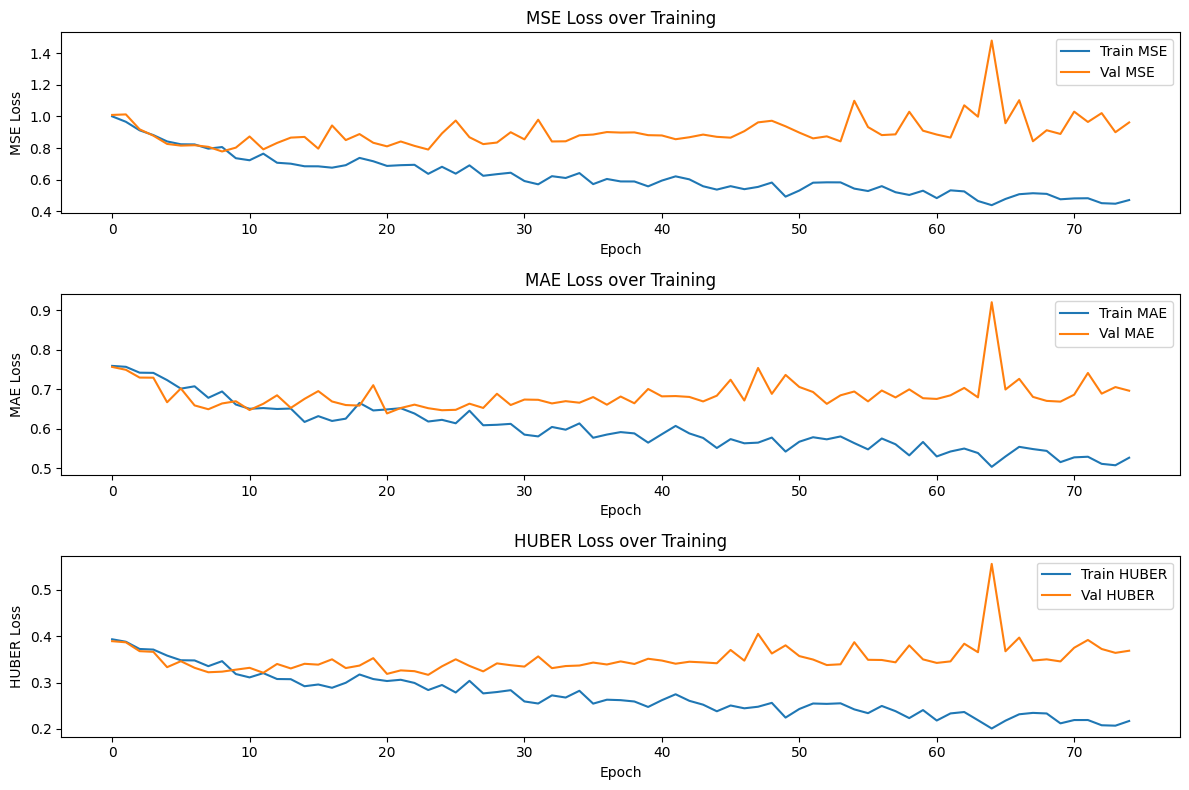

In [25]:

# Plot losses for each metric
plt.figure(figsize=(12, 8))

for i, (name, losses) in enumerate(train_losses.items()):
    plt.subplot(len(train_losses), 1, i+1)
    plt.plot(losses, label=f'Train {name.upper()}')
    plt.plot(val_losses[name], label=f'Val {name.upper()}')
    plt.xlabel("Epoch")
    plt.ylabel(f"{name.upper()} Loss")
    plt.legend()
    plt.title(f"{name.upper()} Loss over Training")

plt.tight_layout()
plt.show()





#### 7) Plot Training and Validation Loss







#### 8) Evaluation on Test Set and Additional Metrics




In [26]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Detach and move to CPU; flatten the predictions.
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)

# Compute Mean Absolute Error (MAE)
mae_val = mean_absolute_error(all_labels, all_preds)

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(all_labels, all_preds)
# Compute R² score
r2_val = r2_score(all_labels, all_preds)

print(f"SROCC:    {spearman_corr:.4f}")
print(f"Pearson:  {pearson_corr:.4f}")
print(f"R^2:      {r2_val:.4f}")
print(f"MAE: {mae_val:.4f}")




SROCC:    0.5957
Pearson:  0.6378
R^2:      0.3043
MAE: 0.5538


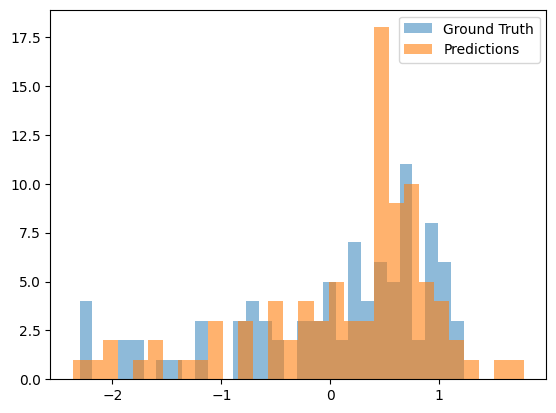

In [27]:
import matplotlib.pyplot as plt

plt.hist(all_labels, bins=30, alpha=0.5, label='Ground Truth')
plt.hist(all_preds, bins=30, alpha=0.6, label='Predictions')
plt.legend()
plt.show()


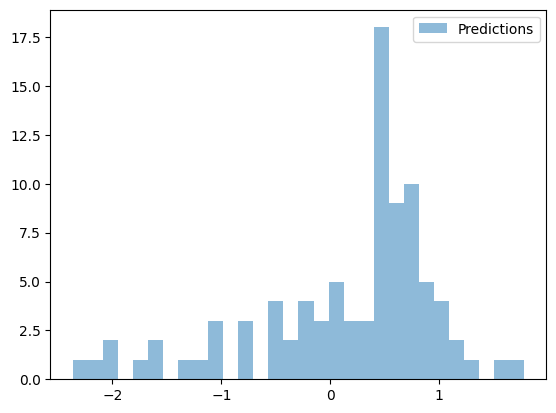

In [28]:
import matplotlib.pyplot as plt

plt.hist(all_preds, bins=30, alpha=0.5, label='Predictions')
plt.legend()
plt.show()


Scatter Plot: Good for a quick check of overall agreement.

Residual Plot: Reveals any patterns or heteroscedasticity in your errors.

Histogram/Density of Residuals: Helps to understand the error distribution.




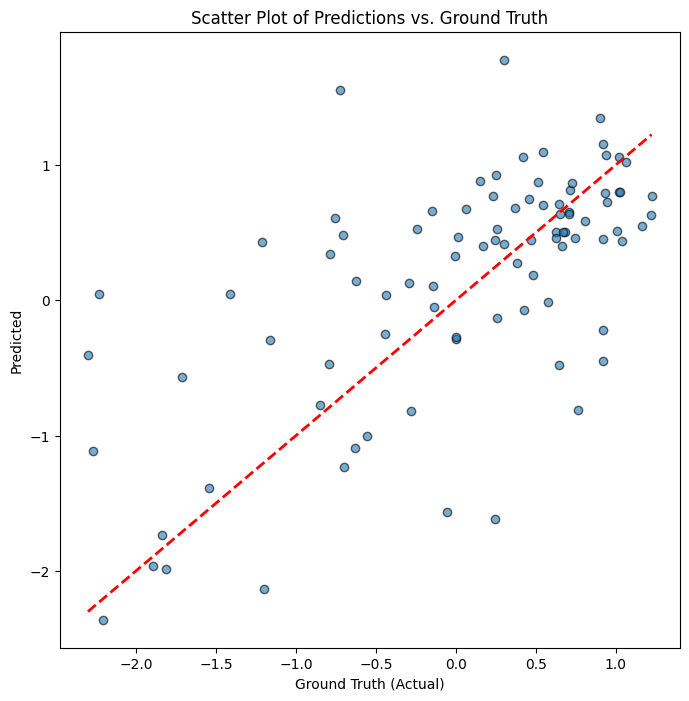

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.6, edgecolors='k')
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--', lw=2)
plt.xlabel('Ground Truth (Actual)')
plt.ylabel('Predicted')
plt.title('Scatter Plot of Predictions vs. Ground Truth')
plt.show()


This plot displays the residuals (i.e., the difference between the ground truth and the predictions) against either the predicted values or the true values. It helps to diagnose patterns in the errors (e.g., heteroscedasticity or non-linearity).


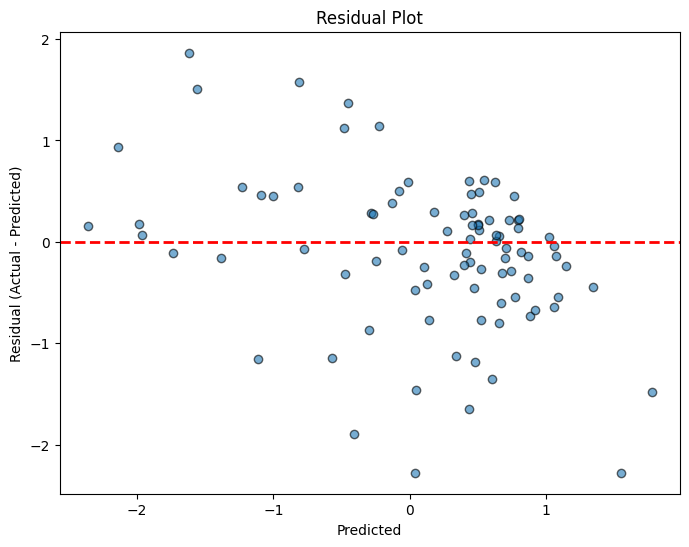

In [30]:
residuals = all_labels - all_preds

plt.figure(figsize=(8, 6))
plt.scatter(all_preds, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()


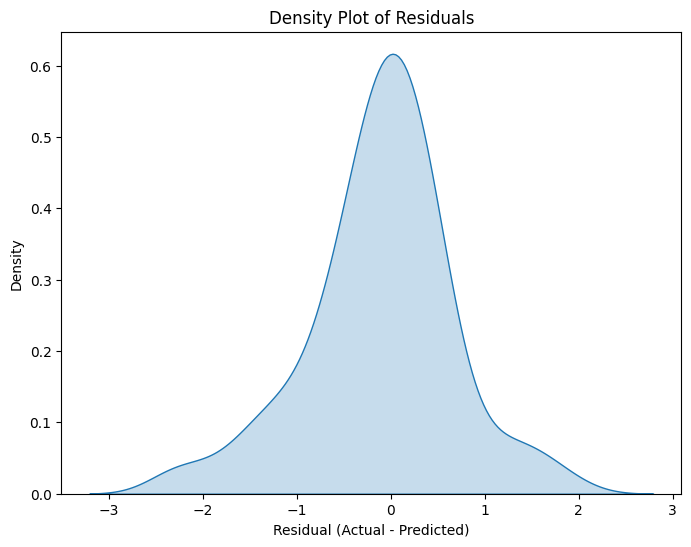

In [31]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, fill=True)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Density Plot of Residuals')
plt.show()


In [32]:

#############################################
# 9) Optional: Print a few predictions vs. ground truth
#############################################
# print("\nSome sample predictions:")
# for i in range(min(5, len(all_preds))):
#     print(f"Predicted (z-score normalized MOS): {all_preds[i]:.3f} | Actual (z-score normalized MOS): {all_labels[i]:.3f}")

# (Optional) If you need to convert the z-score normalized MOS back to the original scale:
def denormalize_mos(z_score_mos):
    return z_score_mos * mos_std + mos_mean

print("\nSome sample predictions (original MOS scale):")
for i in range(min(5, len(all_preds))):
    pred_orig = denormalize_mos(all_preds[i])
    actual_orig = denormalize_mos(all_labels[i])
    print(f"Predicted: {pred_orig:.3f} | Actual: {actual_orig:.3f}")



Some sample predictions (original MOS scale):
Predicted: 72.777 | Actual: 75.843
Predicted: 75.336 | Actual: 76.324
Predicted: 77.312 | Actual: 85.236
Predicted: 71.516 | Actual: 42.999
Predicted: 42.621 | Actual: 51.926


In [33]:
# Save only the model weights (state_dict)
# torch.save(model.state_dict(), '../weights/torch/best_model_weights_base_cnn_correct_zscore_updates.pth')


In [34]:
# Save only the model weights (state_dict)
import datetime

# Format: YYYY-MM-DD_HH-MM-SS
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_time_%H-%M-%S")
print(f"Current timestamp for filename: {timestamp}")

model_name = 'baseCNN'

torch.save(model.state_dict(), f'./weights/torch/{model_name}_{timestamp}_SROCC_{int(spearman_corr*100)}_Pearson_{int(pearson_corr*100)}.pth')


Current timestamp for filename: 2025-05-06_time_00-38-43


In [35]:
all_labels * mos_std + mos_mean


array([75.843124, 76.32376 , 85.23632 , 42.999252, 51.925537, 43.14833 ,
       71.977554, 72.89617 , 50.39706 , 66.6477  , 68.466644, 61.55745 ,
       79.68298 , 81.65584 , 50.287716, 75.24948 , 84.18152 , 80.298065,
       53.155952, 24.706413, 81.70711 , 75.142426, 70.47334 , 82.0784  ,
       71.255455, 70.61026 , 73.448746, 79.91532 , 76.92114 , 64.2537  ,
       65.12859 , 32.572605, 76.35414 , 59.82249 , 72.32991 , 68.402565,
       74.89747 , 63.997463, 68.26595 , 53.111687, 71.36296 , 68.02868 ,
       76.58064 , 64.02835 , 72.1626  , 51.789093, 81.78998 , 75.21942 ,
       73.44619 , 49.269928, 79.92257 , 31.113838, 25.27229 , 77.97334 ,
       80.18475 , 56.34353 , 50.95214 , 81.49191 , 25.73949 , 79.94758 ,
       76.28997 , 66.92138 , 74.053024, 82.50789 , 63.924187, 80.4484  ,
       75.62667 , 39.503628, 54.35688 , 68.27114 , 63.033073, 75.48288 ,
       79.97019 , 61.448536, 69.23367 , 59.15176 , 56.418743, 34.254765,
       85.12217 , 58.92814 , 24.108433, 61.660263, 

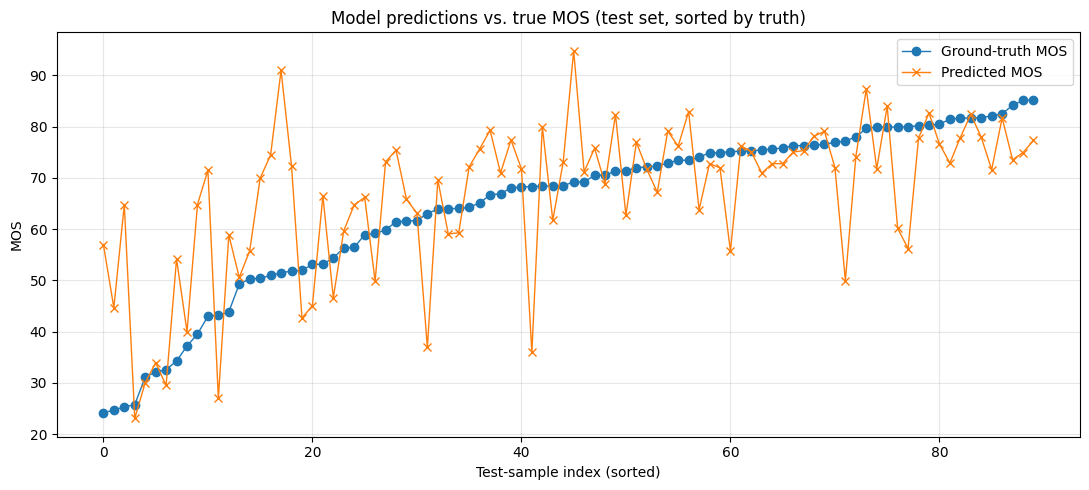

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Go back to the ORIGINAL MOS scale -----------------------
pred_orig   = denormalize_mos(all_preds)   # ← fn you already defined
actual_orig = denormalize_mos(all_labels)

# --- 2) Sort by the true MOS so the plot is easier to read ------
order = np.argsort(actual_orig)            # indices that sort ground‑truth
truth_sorted = actual_orig[order]
pred_sorted  = pred_orig[order]

# --- 3) Line plot -----------------------------------------------
plt.figure(figsize=(11, 5))
plt.plot(truth_sorted, label='Ground‑truth MOS',  marker='o', lw=1)
plt.plot(pred_sorted,  label='Predicted MOS',    marker='x', lw=1)

plt.title('Model predictions vs. true MOS (test set, sorted by truth)')
plt.xlabel('Test‑sample index (sorted)')
plt.ylabel('MOS')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
